In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/T5 Summarizer Training'

/content/gdrive/MyDrive/T5 Summarizer Training


In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd 'tasks'

/content/gdrive/MyDrive/T5 Summarizer Training/tasks


In [ ]:
import torch
import csv
from tqdm import tqdm_notebook, tqdm  # Tqdm progress bar
from torch.utils.data import random_split
from transformers import AutoTokenizer
import evaluate as e

from Summarizer import Summarizer
from train_utils import dataloader, plot_curves

### Set Directory & Device

In [ ]:
# Set folder path
trial = "trial_2023-04-30_17-24_lr_0.001_bs_128"
path = f"../results/{trial}/"

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Functions

In [ ]:
def load_model(path, params):
    checkpoint = torch.load(path)
    model = Summarizer(input_size=params['input_size'], 
                       hidden_size=params['hidden_size'], 
                       output_size=params['output_size'], 
                       device=device, 
                       max_length = params['max_length'], 
                       num_heads=params['num_heads'], 
                       dropout=params['dropout']).to(device)
    model.load_state_dict(checkpoint)
    return model

In [ ]:
# Ref: translate function from A4
def summarize(model, dataloader):
    model.eval()
    with torch.no_grad():
        # Get the progress bar 
        progress_bar = tqdm(dataloader, ascii = True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[:,0].transpose(1,0).to(device)
            target = data[:,1].transpose(1,0).to(device)

            summary = model(source, False)
            return target, summary

In [ ]:
def read_result(path, columns):
    with open(path + 'result.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        result_dict = {}
        for row in csv_reader:
            for i in range(len(columns)):
                key = columns[i]
                result_dict[key] = row[key]
    return result_dict

### Load Model State Dict

In [ ]:
params = ['input_size', 'hidden_size', 'output_size', 'max_length', 'num_heads', 'dropout', 'batch_size']
param_values = read_result(path, params)

for key, value in param_values.items():
    try:
        param_values[key] = int(value)
    except ValueError:
        try:
            param_values[key] = float(value)
        except ValueError:
            pass

In [ ]:
# Load model state and parameters
model = load_model(path+'model_state_dict.pt', param_values)

### Test Model

In [ ]:
# Load preprocessed training data
input_data = torch.load('../data/processed/tokenized_input_data.pt').to(device)
target_data = torch.load('../data/processed/tokenized_target_data.pt').to(device)
data = torch.cat((input_data, target_data), dim=1).to(device)
train_data, val_data, test_data = random_split(data, [0.8, 0.1, 0.1])

# Define data loaders
train_loader, val_loader, test_loader = dataloader(train_data, val_data, test_data, batch_size=param_values['batch_size'])

In [ ]:
target, summary = summarize(model, test_loader)

  0%|          | 0/1 [00:04<?, ?it/s]


In [ ]:
# # Inspect output
# summary.argmax(dim=-1).squeeze().transpose(0,1)
# target.squeeze(dim=0).transpose(0,1)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

decoded_summaries = []
decoded_targets = []

summaries = summary.argmax(dim=-1).squeeze().transpose(0,1).tolist()
targets = target.squeeze(dim=0).transpose(0,1).tolist()
for i in range(len(summaries)): 
    summary_text = tokenizer.decode(summaries[i], skip_special_tokens=True)
    target_text = tokenizer.decode(targets[i], skip_special_tokens=True)

    decoded_summaries.append(summary_text)
    decoded_targets.append(target_text)

    print("Summary: ", summary_text)
    print("Target: ", target_text,'\n')

Summary:  right rightos right right right right right right right right right right right right right right right right right right right right right right
Target:  selective coronary angiography coronary angioplasty acute non st elevation mi 

Summary:  total reductionumomyomy leftomy
Target:  insertion 8 shiley tracheostomy tube 10 blade scalpel used make incision approximately 1 fingerbreadth sternal notch dissection carried using bovie electrocautery level trachea 

Summary:  right rightsco right right right right right right right right right right right right right right right right right right right
Target:  open repair right pectoralis major tendon right pectoralis major tendon rupture mri evaluation complete rupture portion pectoralis major tendon noted 

Summary:  cyarascoomyationoidomy rightos
Target:  normal vasectomy 

Summary:  total reductionos fixation leftomyomy
Target:  echocardiogram doppler 

Summary:  phacoemuls eye eyeacoem cat eye eyeoc cat eye eyeoc eye eye eye 

### ROUGE Score

In [ ]:
rouge = e.load("rouge")
rouge_result = rouge.compute(predictions=decoded_summaries, references=decoded_targets)
rouge_result

{'rouge1': 0.04728101424558169,
 'rouge2': 0.0,
 'rougeL': 0.04708499327168306,
 'rougeLsum': 0.046258711843545644}

### Generate Curves

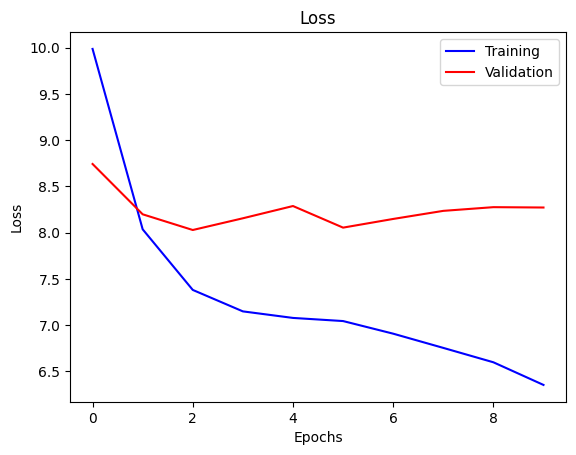

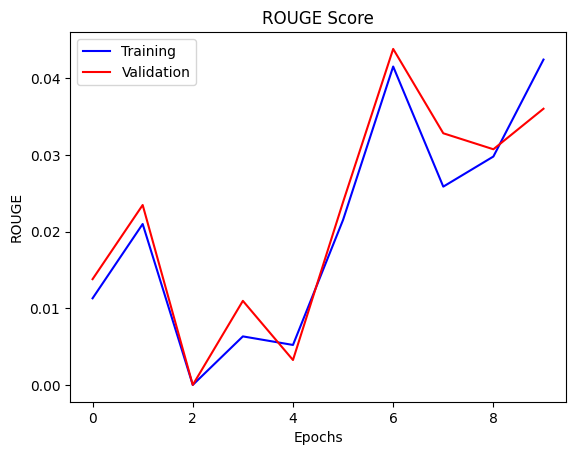

In [ ]:
curves = ['curve_train_loss','curve_val_loss','curve_train_rouge','curve_val_rouge']
history = read_result(path, curves)

for c in history:
    list_value = history[c].strip('[]').split(', ')
    history[c] = [float(x) for x in list_value]

plot_curves(train_loss_history=history['curve_train_loss'], train_rouge_history=history['curve_train_rouge'],
            valid_loss_history=history['curve_val_loss'], valid_rouge_history=history['curve_val_rouge'], path=path)